# Figures

This notebook generates all figures presented in the manuscript:

**“A rigorous statistical benchmark of global neural time-series models for multi-horizon air pollutant forecasting.”**

Its purpose is to:

- Load the processed evaluation results generated by `01_models.ipynb`;
- Compute ranking summaries and frequency distributions;
- Generate Critical Difference (CD) diagrams from Friedman–Nemenyi analysis;
- Produce ranking frequency bubble plots;
- Create Diebold–Mariano heatmaps;
- Summarize spatial Top-3 ranking distributions.
- Perform statistical model comparison using:
  - Friedman test with Iman–Davenport correction;
  - Nemenyi post-hoc analysis;
  - Diebold–Mariano tests with HAC variance estimation;
  - Harvey–Leybourne–Newbold correction;
  - Holm–Bonferroni multiple testing adjustment.

All visual outputs are derived directly from stored experimental results to ensure full reproducibility of the figures reported in the paper.

## Libraries

In [2]:
import itertools
import os
from datetime import date, timedelta

import numpy as np
import pandas as pd
from ridgeplot import ridgeplot

import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
import plotly.io as pio
pio.renderers.default = 'notebook'
from graphmodex import plotlymodex

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from matplotlib import font_manager
import matplotlib as mpl

from bumplot import bumplot

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp 
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests

from statsforecast import StatsForecast

## Data & Config

In [3]:
# ===============================
# CONFIG
# ===============================
steps_per_day = 8
two_year_steps = 2 * 365 * steps_per_day
target_windows = 30

FREQ = '3h'
SEASON_LENGTH = 8 

pollutants_dict = {
        'go3': {
            'scaler': 1e8
        },
        'no2': {
            'scaler': 1e10
        },
        'pm10': {
            'scaler': 1e9
        },
        'pm2p5': {
            'scaler': 1e9
        },
    }
experiments_dict = {
    '1 days': {
        'horizon': 8*1,
        'step_size': max(8*1, two_year_steps // target_windows),
        'windows': target_windows,
    },
    '7 days': {
        'horizon': 8*7,
        'step_size': max(8*7, two_year_steps // target_windows),
        'windows': target_windows,
    },
    '14 days': {
        'horizon': 8*14,
        'step_size': max(8*14, two_year_steps // target_windows),
        'windows': target_windows,
    },
    '30 days': {
        'horizon': 8*30,
        'step_size': 8*30,
        'windows': two_year_steps // (8*30),  # 24
    },
}

database_full = pd.read_csv(r'.\Results\RQ1\full\go3_1days.csv')
database_full = database_full.query("NHITS.notna()")

metrics = pd.read_csv(r'.\Results\RQ1\metrics.csv')

# **Figures**

## ACF & PACF

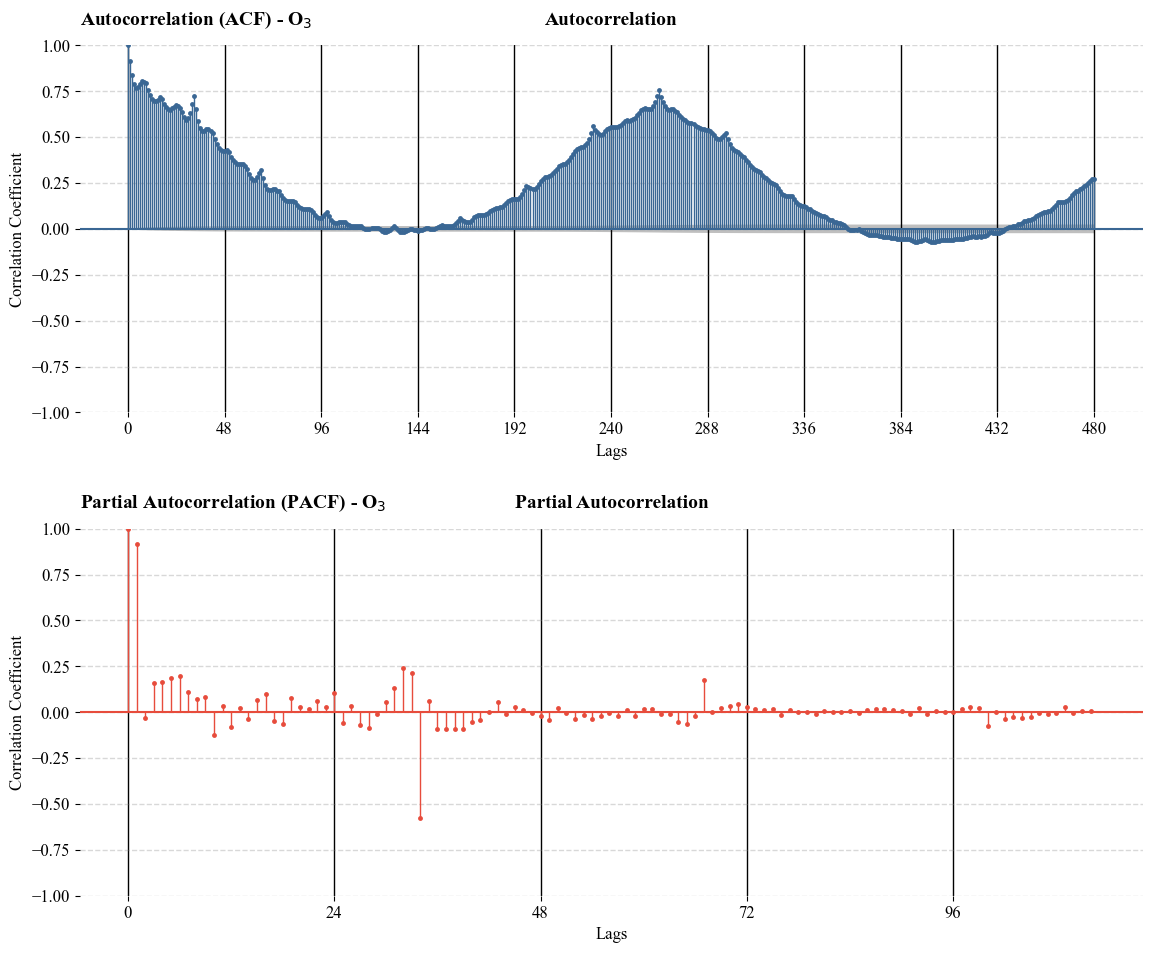

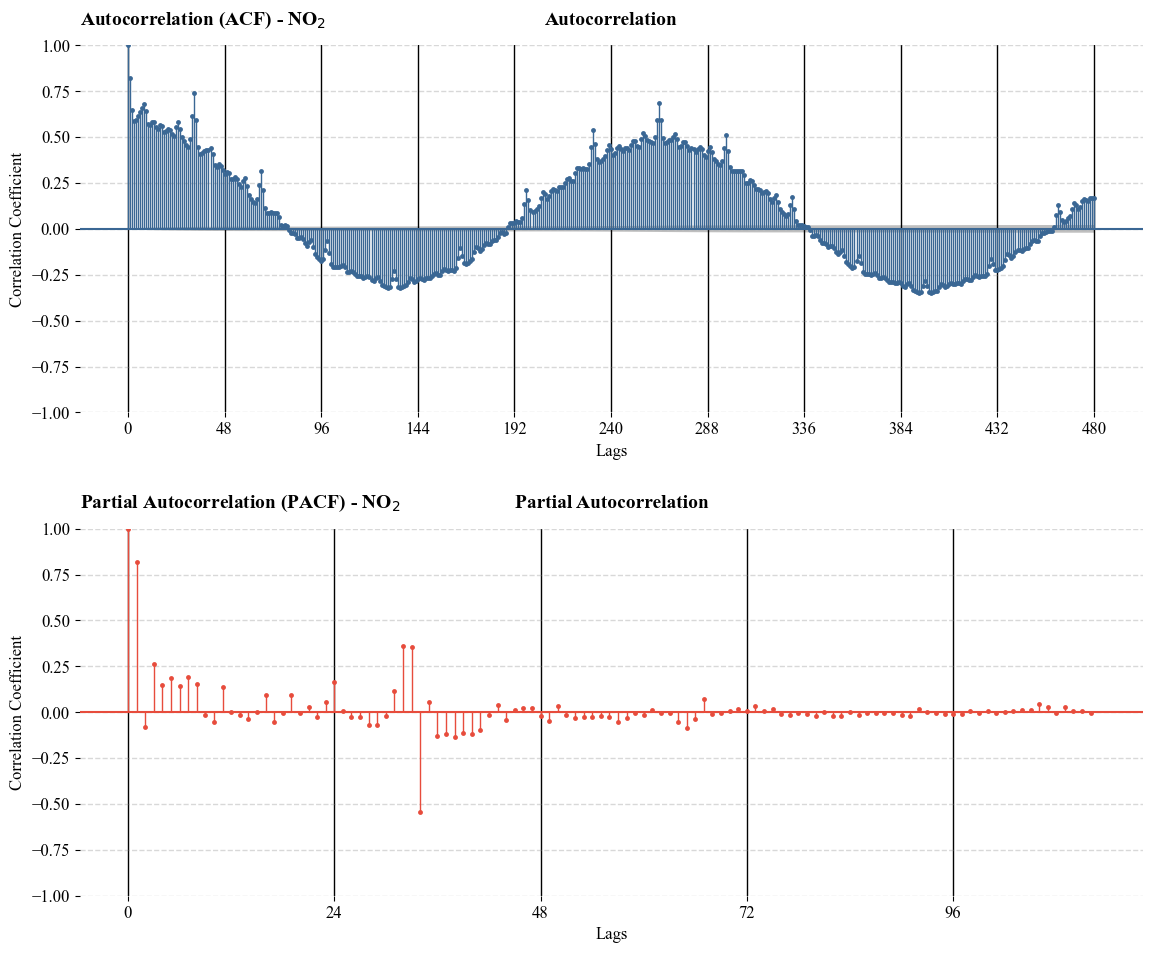

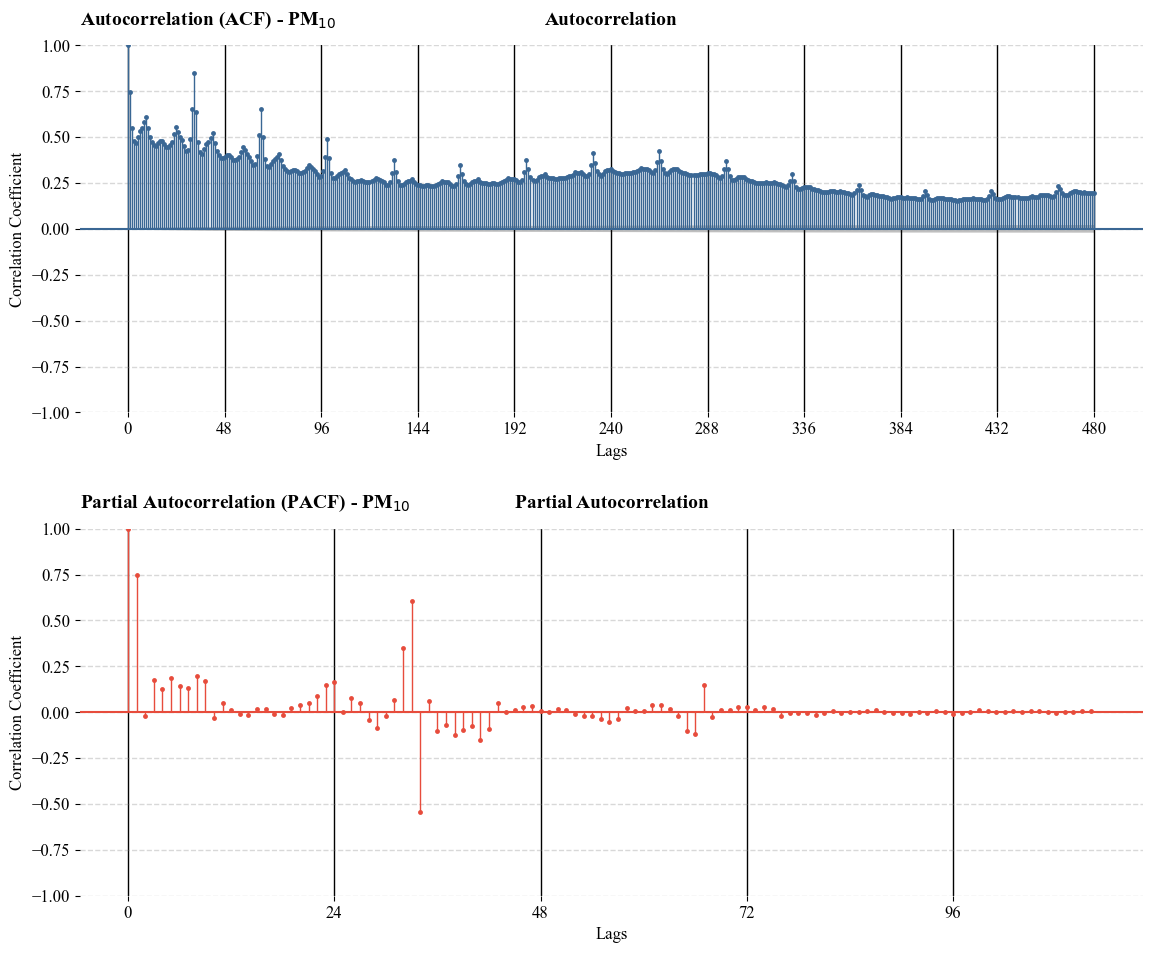

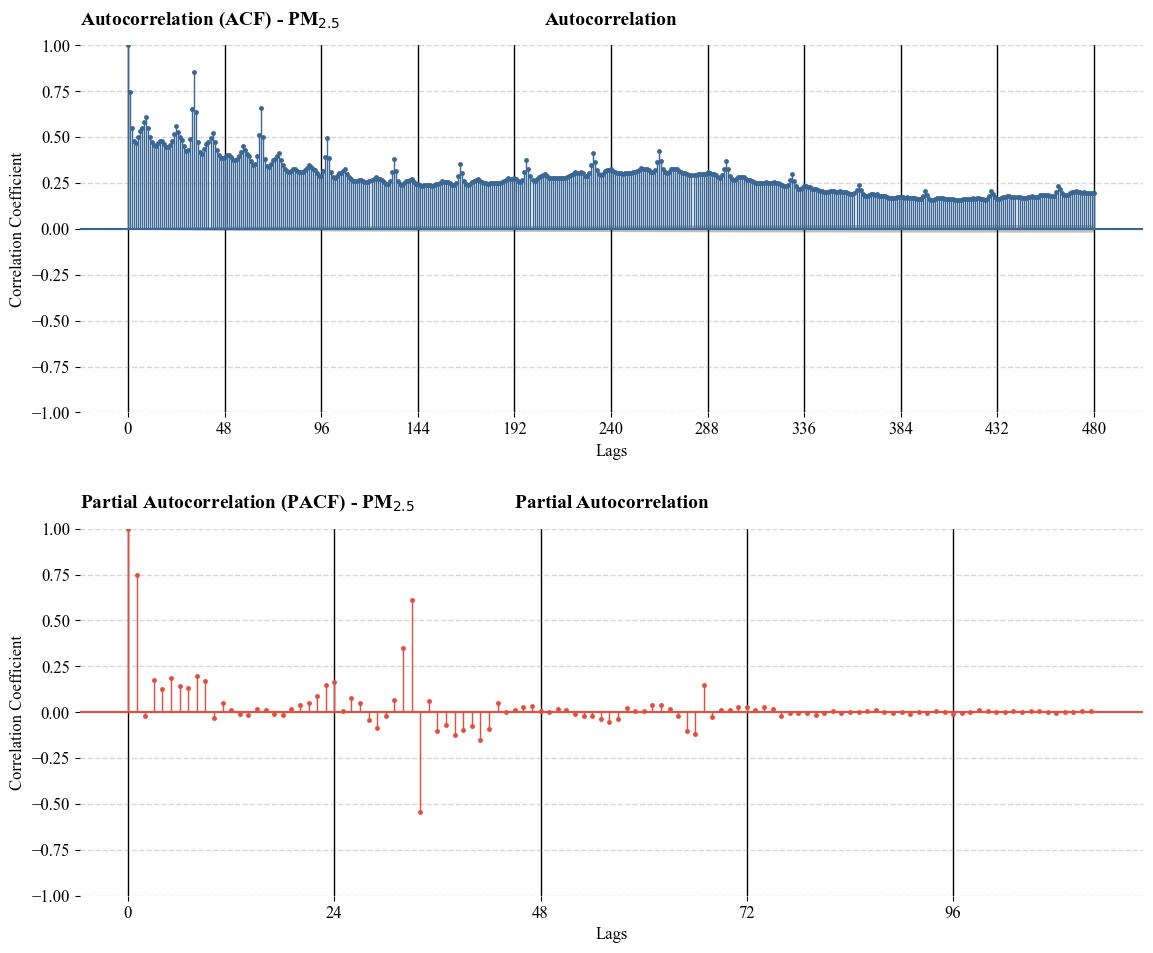

In [ ]:
def plot_acf_pacf_publication(df, pollutant_name, lags_acf=8*60, lags_pacf=8*14, save_path=None):
    """
    Generates ACF and PACF plots following an A1 publication standard.
    """
    # 1. Style configuration (consistent and high-contrast)
    plt.rcParams.update({
        "font.family": "Times New Roman",
        "font.size": 12,
        "axes.edgecolor": "#000000",
        "axes.labelcolor": "#000000",
        "xtick.color": "#000000",
        "ytick.color": "#000000",
        "text.color": "#000000",
        "axes.titlesize": 14,
        "axes.titleweight": "bold"
    })

    # Dictionary of formatted names for title display (LaTeX)
    display_names = {
        "no2": r"NO$_2$",
        "pm10": r"PM$_{10}$",
        "pm2p5": r"PM$_{2.5}$",
        "go3": r"O$_{3}$",
    }
    
    label_pol = display_names.get(pollutant_name.lower(), pollutant_name.upper())
    
    # Data preparation (assuming date filtering has already been done or should be done here)
    # If df is already filtered, the .query can be removed
    data_series = df.query("ds.between('2015-01-01', '2022-12-31')")["y"]

    # 2. Figure creation
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

    v_params_acf = {"colors": "#3a6794", "linewidth": 1.0, "alpha": 1.0}
    v_params_pacf = {"colors": "#e74c3c", "linewidth": 1.0, "alpha": 1.0}

    # --- Plot ACF ---
    plot_acf(data_series, lags=lags_acf, ax=ax1, 
             color="#3a6794", 
             vlines_kwargs=v_params_acf,
             alpha=0.05)
    ax1.set_title(f"Autocorrelation (ACF) - {label_pol}", loc='left', pad=15)

    # --- Plot PACF ---
    plot_pacf(data_series, lags=lags_pacf, ax=ax2, 
              color="#e74c3c", 
              vlines_kwargs=v_params_pacf,
              alpha=0.05)
    ax2.set_title(f"Partial Autocorrelation (PACF) - {label_pol}", loc='left', pad=15)

    # 3. Layout refinement
    for ax in [ax1, ax2]:
        ax.spines[["top", "right"]].set_visible(False)
        ax.spines[["left", "bottom"]].set_edgecolor('black')
        ax.spines[["left", "bottom"]].set_linewidth(1.0)
        
        ax.grid(True, axis='y', linestyle='--', alpha=0.3, color='gray')
        
        ax.set_xlabel("Lags", color='black')
        ax.set_ylabel("Correlation Coefficient", color='black')
        
        for line in ax.get_lines():
            line.set_markersize(3.5)
            line.set_markeredgewidth(0)

    # X-axis tick adjustment (dynamic based on number of lags)
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(base=48))
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(base=12 if lags_pacf <= 100 else 24))

    plt.tight_layout(pad=2.0)

    if save_path:
        plt.savefig(save_path, dpi=600, bbox_inches='tight', facecolor='white')
    
    return fig, (ax1, ax2)


for pol_ in ['go3', 'no2', 'pm10', 'pm2p5']:
    series = pd.read_parquet(rf'.\Results\RQ1\full\{pol_}.parquet')
    fig, axs = plot_acf_pacf_publication(series, f"{pol_}", save_path=f"acf_pacf_{pol_}.png")
    plt.show()

## Statistics

### Metrics

In [389]:
table_metrics = metrics.copy(deep=True)

table_metrics = (
    metrics
    .groupby(['horizon', 'model'])
    .agg(
        MAE_mean=('MAE', 'mean'),
        MAE_std=('MAE', 'std'),
        RMSE_mean=('RMSE', 'mean'),
        RMSE_std=('RMSE', 'std'),
        sMAPE_mean=('sMAPE', 'mean'),
        sMAPE_std=('sMAPE', 'std'),
    )
    .reset_index()
)

table_metrics["MAE"] = table_metrics.apply(
    lambda x: f"{x['MAE_mean']:.3e} ± {x['MAE_std']:.3e}", axis=1
)

table_metrics["RMSE"] = table_metrics.apply(
    lambda x: f"{x['RMSE_mean']:.3e} ± {x['RMSE_std']:.3e}", axis=1
)

table_metrics["sMAPE"] = table_metrics.apply(
    lambda x: f"{x['sMAPE_mean']:.3f} ± {x['sMAPE_std']:.3f}", axis=1
)

# Agora sim podemos selecionar
final_table = table_metrics[
    ["model", "horizon", "MAE", "RMSE", "sMAPE"]
]

table_metrics = table_metrics.sort_values(
    by=["horizon", "MAE_mean"],
    ascending=[True, True]  # menor MAE primeiro
)

table_metrics = table_metrics.query("horizon == '1days'")[["model", "MAE", "RMSE", "sMAPE"]]
# table_metrics.to_excel(r'metrically.xlsx')
table_metrics

,model,MAE,RMSE,sMAPE
23,NHITS,4.377e-09 ± 4.556e-09,5.242e-09 ± 5.351e-09,0.368 ± 0.233
21,NBEATS-G,4.427e-09 ± 4.835e-09,5.290e-09 ± 5.601e-09,0.367 ± 0.233
22,NBEATS-I,4.467e-09 ± 4.851e-09,5.332e-09 ± 5.600e-09,0.372 ± 0.240
20,LightGBM,4.596e-09 ± 6.358e-09,5.466e-09 ± 7.249e-09,0.355 ± 0.227
18,Informer,4.860e-09 ± 5.114e-09,5.727e-09 ± 5.811e-09,0.426 ± 0.236
19,LSTM,5.075e-09 ± 5.412e-09,5.932e-09 ± 6.035e-09,0.417 ± 0.251
17,GRU,5.165e-09 ± 5.517e-09,6.039e-09 ± 6.181e-09,0.424 ± 0.248
15,Arima,5.519e-09 ± 5.772e-09,6.512e-09 ± 6.540e-09,0.453 ± 0.326
28,Theta,5.867e-09 ± 6.937e-09,6.819e-09 ± 7.588e-09,0.443 ± 0.283
27,SeasonalNaive-8,6.041e-09 ± 7.471e-09,7.175e-09 ± 8.762e-09,0.483 ± 0.304


### Nemenyi

In [ ]:
# 1. Create the performance matrix (using MAE as an example)
# Each row represents a unique "test case" and each column a model
df_pivot = metrics.pivot_table(
    index=['pollutant', 'horizon', 'unique_id', 'cutoff'], 
    columns='model', 
    values='MAE'
)

# 1. Preparation (assuming df_pivot has already been created and dropna() applied)
# Reset the index and retain only model columns
# This removes the MultiIndex complexity that previously caused a KeyError
df_clean = df_pivot.reset_index(drop=True)

# 2. Friedman test with Iman-Davenport correction
stat, p_val_classic = stats.friedmanchisquare(*[df_clean[col] for col in df_clean.columns])
n = df_clean.shape[0]  # number of observations
k = df_clean.shape[1]  # number of models
stat_f = ((n - 1) * stat) / (n * (k - 1) - stat)

# 4. Compute the adjusted p-value using the F distribution
# Degrees of freedom: df1 = k-1, df2 = (k-1)*(n-1)
p_val_iman = stats.f.sf(stat_f, k - 1, (k - 1) * (n - 1))

print(f"Friedman (Classic) stat: {stat:.4e}")
print(f"Friedman (Classic) p-value: {p_val_classic:.4e}")
print(f"Iman-Davenport (F-stat) p-value: {p_val_iman:.4e}")
print(f"Iman-Davenport (F-stat) stat: {stat_f:.4e}")

# 3. Nemenyi test
# Passing the DataFrame without the MultiIndex allows the library to work properly
data_nemenyi = sp.posthoc_nemenyi_friedman(df_clean)

# 4. Rank computation for the Critical Difference diagram
# Rank 1 = lowest error (best performance)
ranks = df_clean.rank(axis=1, ascending=True).mean()

Friedman (Classic) stat: 5.9488e+04
Friedman (Classic) p-value: 0.0000e+00
Iman-Davenport (F-stat) p-value: 0.0000e+00
Iman-Davenport (F-stat) stat: 5.9207e+03



--- Processando Horizonte: 14days ---
Friedman p-value: 0.0000e+00
Salvo: CD_Diagram_MAE_14days.png


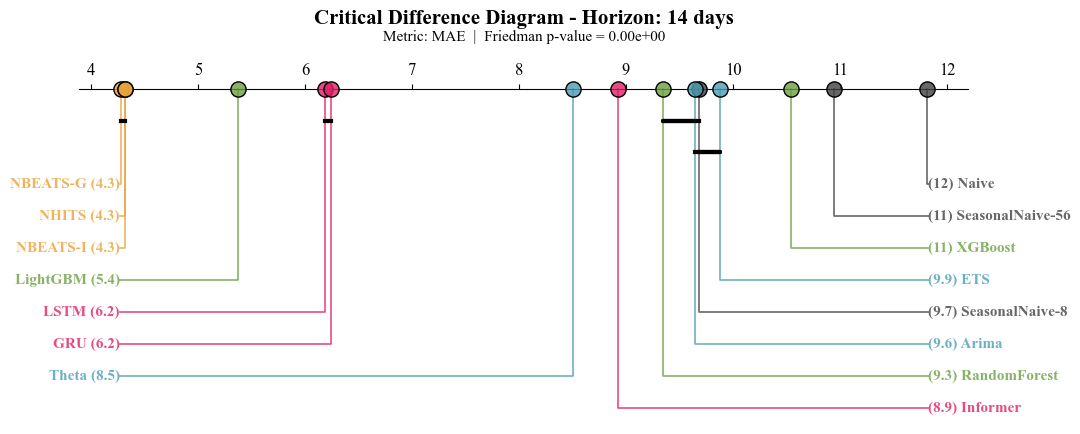


--- Processando Horizonte: 1days ---
Friedman p-value: 0.0000e+00
Salvo: CD_Diagram_MAE_1days.png


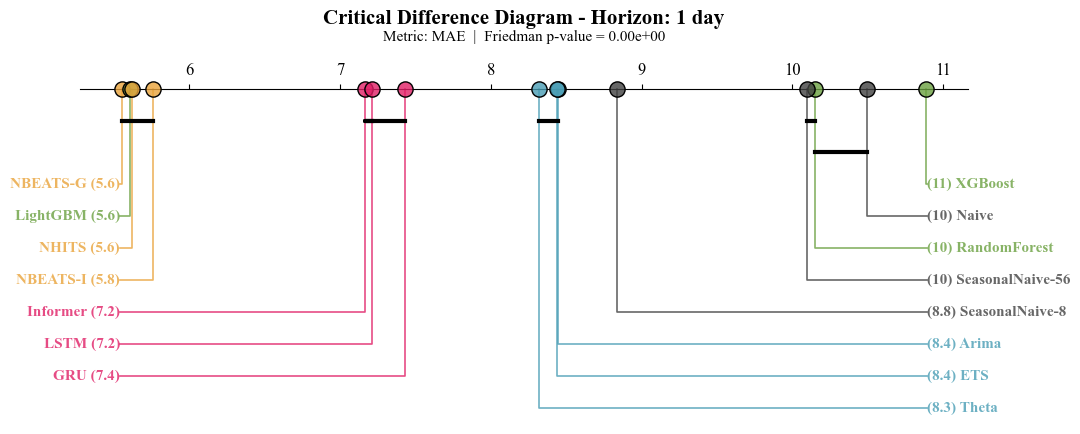


--- Processando Horizonte: 30days ---
Friedman p-value: 0.0000e+00
Salvo: CD_Diagram_MAE_30days.png


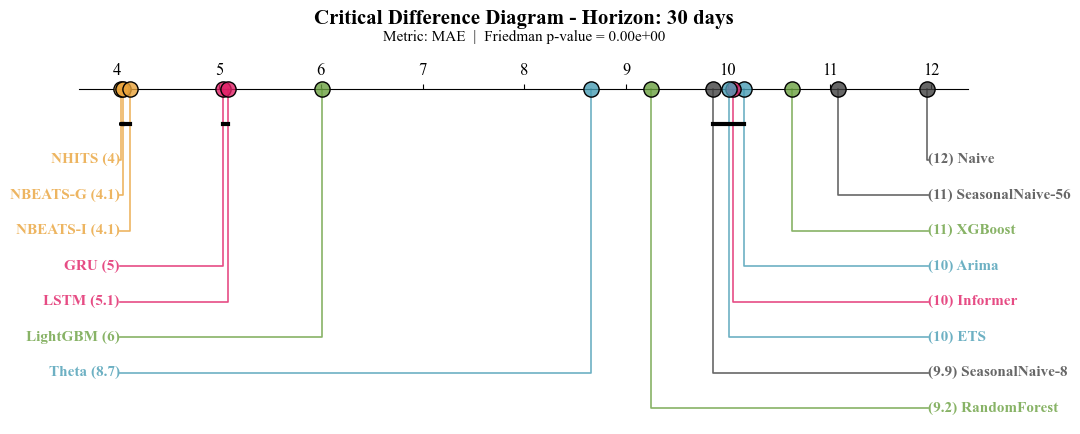


--- Processando Horizonte: 7days ---
Friedman p-value: 0.0000e+00
Salvo: CD_Diagram_MAE_7days.png


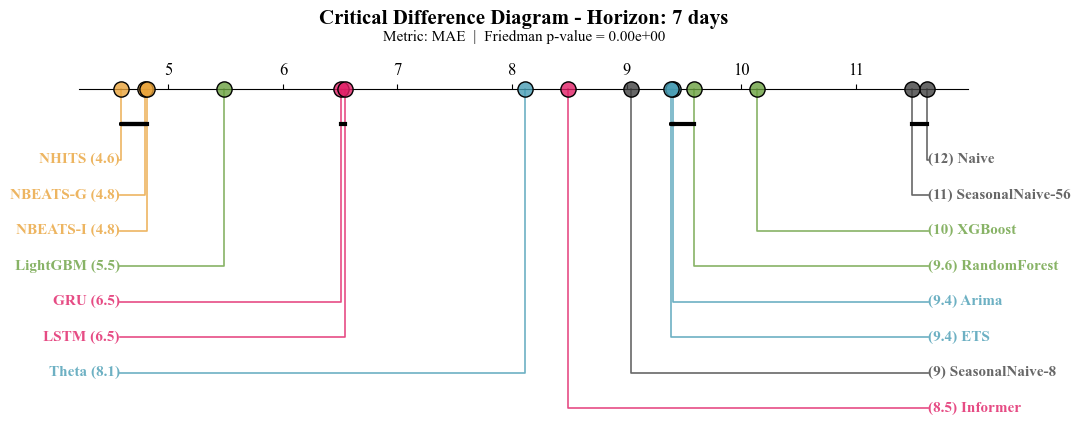

In [ ]:
# =========================================================
# 1. GLOBAL CONFIGURATION (Journal Style - Times New Roman)
# =========================================================
plt.rcdefaults()
mpl.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "font.size": 12
})

categories = {
    "Statistical": {"Arima", "ETS", "Theta"},
    "Machine Learning": {"RandomForest", "XGBoost", "LightGBM"},
    "Deep Learning": {"LSTM", "GRU", "Informer"},
    "Neural": {"NHITS", "NBEATS-G", "NBEATS-I"},
    "Benchmark": {"Naive", "SeasonalNaive-8", "SeasonalNaive-56"}
}

color_palette = {
    "Statistical": "#489db4cc", "Machine Learning": "#6aa040cc",
    "Deep Learning": "#e01f66cc", "Neural": "#e9a33acc", "Benchmark": "#414141cc"
}

# =========================================================
# 2. LOOP OVER FORECAST HORIZONS
# =========================================================
horizontes = metrics['horizon'].unique()

for hor in horizontes:
    print(f"\n--- Processing Horizon: {hor} ---")
    
    df_h = metrics[metrics['horizon'] == hor]
    
    df_pivot = df_h.pivot_table(
        index=['pollutant', 'unique_id', 'cutoff'], 
        columns='model', 
        values='MAE'
    ).dropna()

    if df_pivot.empty:
        continue

    df_nemenyi_input = df_pivot.reset_index(drop=True)
    
    # Friedman test (uses the cleaned matrix)
    stat, p_val = friedmanchisquare(*[df_nemenyi_input[col] for col in df_nemenyi_input.columns])
    print(f"Friedman p-value: {p_val:.4e}")

    # Nemenyi test 
    data_nemenyi = sp.posthoc_nemenyi_friedman(df_nemenyi_input)

    ranks = df_pivot.rank(axis=1, ascending=True).mean().sort_values()
    hue = pd.Series(index=ranks.index, dtype="object")
    for model in ranks.index:
        found = False
        for cat, models in categories.items():
            if model in models:
                hue[model] = cat
                found = True
        if not found: 
            hue[model] = "Other"

    # 7. Plotting the Critical Difference Diagram
    fig, ax = plt.subplots(figsize=(11, 4.5))
    
    # Extract numeric horizon value (remove 'days')
    hor_num = int(hor.replace("days", ""))
    # Elegant formatting (correct singular/plural)
    hor_label = f"{hor_num} day" if hor_num == 1 else f"{hor_num} days"
    title_main = f"Critical Difference Diagram - Horizon: {hor_label}"
    subtitle = f"Metric: MAE  |  Friedman p-value = {p_val:.2e}"

    ax.set_title(title_main, fontweight='bold', fontsize=15, pad=35, family='serif')
    ax.text(0.5, 1.09, subtitle, transform=ax.transAxes, ha='center', fontsize=11, family='serif')

    # Generate the diagram
    sp.critical_difference_diagram(
        ranks,
        data_nemenyi,
        ax=ax,
        hue=hue,
        color_palette=color_palette,
        label_props={"fontsize": 11, "fontweight": "bold"},
        marker_props={"s": 120, "edgecolor": "black", "linewidths": 1},
        elbow_props={"linewidth": 1.2},
        crossbar_props={"linewidth": 3, "color": "black"},
        text_h_margin=0.01
    )

    # Force Times New Roman font in all plot elements
    for text in ax.findobj(match=mpl.text.Text):
        text.set_fontfamily("serif")
        text.set_fontname("Times New Roman")

    plt.tight_layout()
    
    # Save each horizon as a separate file
    file_name = f"CD_Diagram_MAE_{hor}.png"
    plt.savefig(file_name, format="png", bbox_inches="tight")
    print(f"Saved: {file_name}")
    
    plt.show()

### Diebold-Mariano

In [ ]:
# =========================================================
# Diebold–Mariano Test with HAC Variance and HLN Correction
# =========================================================
def diebold_mariano_test(target, forecast_m1, forecast_m2, h=1):
    """
    Computes the Diebold–Mariano (DM) test for equal predictive accuracy
    using absolute error loss (MAE).

    The test incorporates:
        - Heteroskedasticity and autocorrelation consistent (HAC)
          long-run variance estimation via Bartlett kernel (Newey–West);
        - Harvey–Leybourne–Newbold (HLN) small-sample correction
          for multi-step forecasting.

    Parameters
    ----------
    target : array-like
        Observed values.
    forecast_m1 : array-like
        Forecasts from model 1.
    forecast_m2 : array-like
        Forecasts from model 2.
    h : int
        Forecast horizon (number of steps ahead).

    Returns
    -------
    dm_stat_hln : float
        HLN-adjusted DM statistic.
    p_value : float
        Two-sided p-value based on Student's t distribution.
    """

    # Absolute error loss differential
    e1 = np.abs(target - forecast_m1)
    e2 = np.abs(target - forecast_m2)
    d = e1 - e2
    T = len(d)

    def autocovariance(x, lag):
        if lag == 0:
            return np.var(x)
        if len(x) <= lag:
            return 0
        return np.cov(x[lag:], x[:-lag])[0][1]

    # -----------------------------------------------------
    # Long-run variance estimation (Newey–West / Bartlett)
    # -----------------------------------------------------
    v_hat = autocovariance(d, 0)
    for k in range(1, h):
        v_hat += 2 * (1 - k / h) * autocovariance(d, k)

    # Safeguard against degenerate variance estimates
    if v_hat <= 0:
        return 0, 1.0

    dm_stat = np.mean(d) / np.sqrt(v_hat / T)

    # -----------------------------------------------------
    # Harvey–Leybourne–Newbold (HLN) correction
    # -----------------------------------------------------
    hln_correction = np.sqrt((T + 1 - 2 * h + (h / T) * (h - 1)) / T)
    dm_stat_hln = hln_correction * dm_stat

    p_value = 2 * stats.t.sf(np.abs(dm_stat_hln), df=T - 1)

    return dm_stat_hln, p_value


# =========================================================
# Execution of Pairwise DM Tests
# =========================================================
pollutants = ['go3', 'pm10', 'pm2p5', 'no2']
horizons = {'1days': 8, '7days': 56, '14days': 112, '30days': 240}
base_path = r'..\Masters 26\Results\RQ1\full'

all_models = [
    'NHITS', 'NBEATS-G', 'NBEATS-I', 'Arima', 'ETS', 'Theta',
    'LightGBM', 'RandomForest', 'XGBoost', 'GRU', 'LSTM', 'Informer',
    'Naive', 'SeasonalNaive-8', 'SeasonalNaive-56'
]

raw_results = []

for pol in pollutants:
    for hor, lag in horizons.items():

        file_path = os.path.join(base_path, f'{pol}_{hor}.csv')
        if not os.path.exists(file_path):
            continue

        df = pd.read_csv(file_path)

        # -------------------------------------------------
        # Pairwise comparisons across all model combinations
        # -------------------------------------------------
        for m1, m2 in itertools.combinations(all_models, 2):
            if m1 in df.columns and m2 in df.columns:

                stat, p = diebold_mariano_test(
                    df['y'],
                    df[m1],
                    df[m2],
                    h=lag
                )

                raw_results.append({
                    'Pollutant': pol.upper(),
                    'Horizon': hor,
                    'Model1': m1,
                    'Model2': m2,
                    'DM_Stat': stat,
                    'p-value': p
                })


# =========================================================
# Holm–Bonferroni Multiple Testing Correction
# =========================================================
# Family-wise error control is applied within each
# experimental block (Pollutant × Horizon).

df_final = pd.DataFrame(raw_results)

def apply_holm_correction(group):
    """
    Applies Holm–Bonferroni correction within a
    pollutant–horizon experimental block.
    """
    rejected, p_corrected, _, _ = multipletests(
        group['p-value'],
        alpha=0.05,
        method='holm'
    )

    group['p-value-corrected'] = p_corrected
    group['Significant_05'] = ["Yes" if r else "No" for r in rejected]

    return group

df_final = (
    df_final
    .groupby(['Pollutant', 'Horizon'])
    .apply(apply_holm_correction)
)


# =========================================================
# Inferential Superiority Determination
# =========================================================
def determine_winner(row):
    """
    Determines the statistically superior model based on:

        - Holm-adjusted significance
        - Sign of the HLN-adjusted DM statistic

    Interpretation:
        DM_Stat < 0  → Model1 has lower loss
        DM_Stat > 0  → Model2 has lower loss
    """
    if row['Significant_05'] == "No":
        return "Tie (Equal)"

    return row['Model1'] if row['DM_Stat'] < 0 else row['Model2']

df_final['Superior_Model'] = df_final.apply(determine_winner, axis=1)


# =========================================================
# Export Results
# =========================================================
df_final.to_csv("DM_Tests_Holm_Corrected.csv", index=False)

print("Diebold–Mariano tests completed with Holm–Bonferroni correction.")

Testes DM concluídos com correção de Holm-Bonferroni.


C:\Users\gustavo.filho\AppData\Local\Temp\ipykernel_23952\3364963804.py:76: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [ ]:
# =========================================================
# Data Preparation for Visualization
# =========================================================

df_plot_ready = df_final.copy()
if df_plot_ready.index.name is not None:
    df_plot_ready = df_plot_ready.reset_index()

df_plot_ready = df_plot_ready.loc[:, ~df_plot_ready.columns.duplicated()]
df_plot_ready.index = range(len(df_plot_ready))
df_plot_ready.index.name = None


# =========================================================
# Universal Statistical Dominance Heatmap
# =========================================================

def plot_universal_dominance(results_df, target_pollutant, focal_model='NHITS'):
    """
    Generates a statistical dominance heatmap for a focal model
    based on Holm–Bonferroni corrected Diebold–Mariano tests.

    Parameters
    ----------
    results_df : pd.DataFrame
        DataFrame containing DM test results with corrected p-values.
    target_pollutant : str
        Pollutant identifier.
    focal_model : str, default='NHITS'
        Reference model for dominance comparison.

    Returns
    -------
    plotly.graph_objects.Figure
        Heatmap summarizing statistical superiority relationships.
    """

    # -----------------------------------------------------
    # Initial filtering by pollutant
    # -----------------------------------------------------
    df_temp = results_df[results_df['Pollutant'] == target_pollutant.upper()].copy()
    
    # Retain only pairwise tests involving the focal model
    mask = (df_temp['Model1'] == focal_model) | (df_temp['Model2'] == focal_model)
    df_filtered = df_temp[mask].copy()

    if df_filtered.empty:
        return None

    # -----------------------------------------------------
    # Determine opponent model and dominance score
    # -----------------------------------------------------
    def get_score(row):
        opponent = row['Model2'] if row['Model1'] == focal_model else row['Model1']

        if row['Superior_Model'] == focal_model:
            score = 1          # Focal model statistically superior
        elif row['Superior_Model'] == 'Tie (Equal)':
            score = 0          # No significant difference
        else:
            score = -1         # Focal model statistically inferior

        return pd.Series([opponent, score], index=['Opponent', 'Score'])

    df_filtered[['Opponent', 'Score']] = df_filtered.apply(get_score, axis=1)

    # -----------------------------------------------------
    # Pivot construction via groupby to avoid ambiguity
    # -----------------------------------------------------
    pivot_heat = (
        df_filtered
        .groupby(['Opponent', 'Horizon'])['Score']
        .mean()
        .unstack()
    )

    # -----------------------------------------------------
    # Axis reordering (consistent across figures)
    # -----------------------------------------------------
    models_order = [
        'NHITS', 'NBEATS-G', 'NBEATS-I', 
        'GRU', 'LSTM', 'Informer',
        'LightGBM',
        'ETS',
    ]

    y_order = [
        m for m in list(reversed(models_order))
        if m in pivot_heat.index and m != focal_model
    ]

    h_order = ['1days', '7days', '14days', '30days']
    
    pivot_heat = pivot_heat.reindex(
        index=y_order,
        columns=[h for h in h_order if h in pivot_heat.columns]
    )

    # -----------------------------------------------------
    # Symbolic matrix (↑, =, ↓)
    # -----------------------------------------------------
    label_map = {-1: "↓", 0: "=", 1: "↑"}
    text_matrix = np.vectorize(
        lambda x: label_map.get(x, ""),
        otypes=[object]
    )(pivot_heat.values)

    # -----------------------------------------------------
    # Heatmap generation
    # -----------------------------------------------------
    fig = go.Figure(data=go.Heatmap(
        z=pivot_heat.values,
        x=pivot_heat.columns,
        y=pivot_heat.index,
        zmin=-1,
        zmax=1,
        colorscale=[
            [0.0, "#A74752"],   # Inferior
            [0.5, "#F7F7F7"],   # Tie
            [1.0, "#2FB669"]    # Superior
        ],
        showscale=False,
        text=text_matrix,
        texttemplate="%{text}",
        textfont=dict(family="Times New Roman", size=14),
        xgap=4,
        ygap=4
    ))

    fig.update_layout(
        title=(
            f"<b>Statistical Dominance: {focal_model} Base</b>"
            f"<br><sup>Pollutant: {target_pollutant.upper()} | "
            f"Holm–Bonferroni Corrected</sup>"
        ),
        
        font=dict(family="Times New Roman", size=14),

        margin=dict(l=40, r=20, t=80, b=40),

        annotations=[
            dict(
                text="<b>Legend:</b> (↑) Superior&nbsp; (=) No Significant Difference&nbsp; (↓) Inferior",
                x=0.99,
                y=1.065,
                xref="paper",
                yref="paper",
                showarrow=False,
                font=dict(size=11),
                align="right"
            )
        ],

        xaxis=dict(
            tickmode='array',
            tickvals=pivot_heat.columns,
            ticktext=['1 day', '7 days', '14 days', '30 days'][:len(pivot_heat.columns)]
        ),

        yaxis=dict(
            tickmode='array',
            tickvals=pivot_heat.index,
            ticktext=[f"{m} " for m in pivot_heat.index]
        ),

        width=450,
        height=400,
        plot_bgcolor="white"
    )
    
    return fig


# =========================================================
# Figure Generation Loop
# =========================================================
figs_ = []

for pol_ in ['PM10', 'PM2P5', 'NO2', 'GO3']:
    for model_ in ['NHITS']:
        fig = plot_universal_dominance(
            df_plot_ready,
            pol_,
            focal_model=model_
        )

        figs_.append(fig)

In [ ]:
# Figure subplots
fig = plotlymodex.subplot(
    figs_, 
    legends=[0, 0, 0, 0],
    rows=2, cols=2, 
    shared_xaxes=True, 
    shared_yaxes=True, 
    title="<b>Universal Dominance Heatmaps: N-HiTS Base</b>",
    subplot_titles=[r'$\text{PM}_{10}$', r'$\text{PM}_{2.5}$', r'$\text{NO}_{2}$', r'$\text{O}_{3}$'],
    width=900, 
    height=800, 
    vertical_spacing=0.07, 
    horizontal_spacing=0.03 
)

fig.update_layout(
    font=dict(family="Times New Roman", size=14),
    
    annotations=list(fig.layout.annotations) + [
        dict(
            text="Legend: (↑) Superior  (=) No Significant Difference  (↓) Inferior",
            x=0.136,
            y=1.09, # Ajustado levemente para acomodar o título em negrito
            xref="paper",
            yref="paper",
            showarrow=False,
            font=dict(size=13, color="gray"),
            xanchor="center"
        )
    ],
    plot_bgcolor="white",
    margin=dict(t=120, b=50, l=10, r=20) # Aumentei t para 130 para dar mais respiro ao topo
)

for annot in fig.layout.annotations:
    if annot.text in [r'$\text{PM}_{10}$', r'$\text{PM}_{2.5}$', r'$\text{NO}_{2}$', r'$\text{O}_{3}$']:
        annot.font.size = 18
        annot.y += 0.01 

fig.update_xaxes(title_text="", showgrid=False)
fig.update_yaxes(title_text="", showgrid=False)

fig.show()
filename = f"universal_dominance_{model_}.png"
fig.write_image(filename, scale=3)

### Metrics Table

In [395]:
table_metrics = metrics.copy(deep=True)

table_metrics = (
    metrics
    .groupby(['horizon', 'model'])
    .agg(
        MAE_mean=('MAE', 'mean'),
        MAE_std=('MAE', 'std'),
        RMSE_mean=('RMSE', 'mean'),
        RMSE_std=('RMSE', 'std'),
        sMAPE_mean=('sMAPE', 'mean'),
        sMAPE_std=('sMAPE', 'std'),
    )
    .reset_index()
)

# Ordenar por horizonte e MAE
table_metrics = table_metrics.sort_values(
    by=["horizon", "MAE_mean"],
    ascending=[True, True]
)

# Selecionar versão numérica
final_table_numeric = table_metrics[
    [
        "model",
        "horizon",
        "MAE_mean",
        "RMSE_mean",
        "sMAPE_mean", 
    ]
]

final_table_numeric = final_table_numeric.query("horizon == '1days'")
final_table_numeric.to_excel(r'metricallyyy.xlsx')
final_table_numeric

,model,horizon,MAE_mean,RMSE_mean,sMAPE_mean
23,NHITS,1days,4.376501e-09,5.241520e-09,0.368495
21,NBEATS-G,1days,4.426725e-09,5.289501e-09,0.366766
22,NBEATS-I,1days,4.466920e-09,5.332026e-09,0.371818
20,LightGBM,1days,4.596230e-09,5.466207e-09,0.354840
18,Informer,1days,4.860019e-09,5.727180e-09,0.426440
19,LSTM,1days,5.075217e-09,5.932022e-09,0.417212
17,GRU,1days,5.165283e-09,6.038702e-09,0.424370
15,Arima,1days,5.518997e-09,6.511801e-09,0.453485
28,Theta,1days,5.866775e-09,6.818565e-09,0.443107
27,SeasonalNaive-8,1days,6.041002e-09,7.175056e-09,0.483210


## Ranking Bubble Plot

In [ ]:
metrics_ = metrics.copy()

# ==========================================
# MODEL FILTERING
# ==========================================
models_to_keep = [
    'NHITS', 'NBEATS-G', 'NBEATS-I', 
    'LightGBM', 
    'GRU', 'LSTM', 'Informer',
    'Arima', 'ETS', 'Theta',
] 

metrics_ = metrics_[metrics_['model'].isin(models_to_keep)]

# 1. Exact Mapping and Internationalization of Model Categories
model_to_group = {
    'NHITS': 'Neural', 'NBEATS-G': 'Neural', 'NBEATS-I': 'Neural',
    'LightGBM': 'ML', 'RandomForest': 'ML', 'XGBoost': 'ML',
    'Arima': 'Statistical', 'ETS': 'Statistical', 'Theta': 'Statistical',
    'GRU': 'dl', 'LSTM': 'dl', 'Informer': 'dl',
}

group_colors = {
    'Neural': "#e9a33a",
    'ML': "#7cb153",
    'Statistical': '#5cc8e6',
    'Benchmark': "#C9C9C9",
    'dl': "#e94983",
}

# Compute ranking (Rank 1 = lowest MAE)
metrics_['ranking'] = metrics_.groupby(
    ['pollutant', 'horizon', 'unique_id', 'cutoff']
)['MAE'].rank(method='dense', ascending=True)

# Aggregate ranking frequencies
metrics_ = metrics_.groupby(['horizon', 'model', 'ranking']).agg({
    'pollutant': 'count'
}).reset_index()

# Normalization per model (ensures total frequency sums to 100%)
metrics_['rel_freq'] = metrics_.groupby(
    ['horizon', 'model']
)['pollutant'].transform(lambda x: (x / x.sum()) * 100)

# 2. Map Model Groups and Corresponding Colors
metrics_['group'] = metrics_['model'].map(model_to_group)
metrics_['color'] = metrics_['group'].map(group_colors)

# 3. Model Ordering by Group
group_order = ['Neural', 'dl', 'ML', 'Statistical', 'Benchmark']
metrics_['group'] = pd.Categorical(
    metrics_['group'],
    categories=list(reversed(group_order)),
    ordered=True
)

metrics_ = metrics_.sort_values(by=['group', 'model'], ascending=[False, True])

# --- Horizon Label Mapping for Publication-Ready Titles ---
horizon_display_names = {
    '1days': '1 Day',
    '7days': '7 Days',
    '14days': '14 Days',
    '30days': '30 Days'
}

# Horizon Ordering
horizon_order = ['1days', '7days', '14days', '30days']
unique_horizons = [h for h in horizon_order if h in metrics_['horizon'].unique()]

for horizon in unique_horizons:
    horizon_data = metrics_[metrics_['horizon'] == horizon]
    
    # Retrieve formatted horizon label
    title_horizon = horizon_display_names.get(horizon, horizon)
    
    fig_item = go.Figure()
    
    fig_item.add_trace(go.Scatter(
        x=horizon_data['ranking'], 
        y=horizon_data['model'], 
        mode='markers+text',
        name=horizon,
        marker=dict(
            size=70 * horizon_data['pollutant'] / horizon_data['pollutant'].max(), 
            color=horizon_data['color'],
            opacity=0.7,
            line=dict(width=0.8, color='black')
        ),
        text=horizon_data['rel_freq'].round(1).astype(str) + '%',
        textposition="middle center",
        textfont=dict(family="Times New Roman", size=11, color="black")
    ))

    fig_item.update_yaxes(
        categoryorder='array',
        categoryarray=metrics_['model'].unique()[::-1],
        showgrid=True,
        gridcolor='rgba(0,0,0,0.05)',
        linecolor='black',
        mirror=True
    )
    
    max_rank = metrics_['ranking'].max() + 0.5

    fig_item.update_xaxes(
        range=[0.1, max_rank + 0.4],
        title_text="Ranking Position",
        dtick=1,
        showgrid=True,
        gridcolor='rgba(0,0,0,0.1)',
        linecolor='black',
        mirror=True
    )

    fig_item.update_layout(
        title=f'Model Ranking Distribution - Horizon: {title_horizon}',
        font=dict(family="Times New Roman", size=15, color="black"),
        title_font=dict(size=22),
        plot_bgcolor='white',
        margin=dict(l=40, r=10, t=40, b=60),
        showlegend=False,
        height=550,
        width=750
    )

    fig_item.show()
    # filename = f"bubbleplot_h{horizon}.png"
    # fig_item.write_image(filename, scale=3)

print("\nRow sum verification (should equal 100.0 for all models):")
print(metrics_.groupby(['horizon', 'model'])['rel_freq'].sum().unstack(level=0))

In [ ]:
def get_top_n_table(df, r=3):
    """
    Generates a summary table reporting the cumulative relative frequency
    of models appearing within the top 'r' ranking positions.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing ranking frequencies and relative frequencies.
    r : int, default=3
        Maximum ranking position to be considered (e.g., Top-3, Top-5).

    Returns
    -------
    pd.DataFrame
        Formatted pivot table (percentage values) indexed by model
        and organized by forecast horizon.
    """

    # Filter models appearing within ranking positions 1 to r
    top_n_data = df[df['ranking'] <= r].copy()
    
    # Aggregate relative frequency for each model and horizon
    table = (
        top_n_data
        .groupby(['horizon', 'model'])['rel_freq']
        .sum()
        .reset_index()
    )
    
    # Pivot so that horizons become columns (report-style format)
    pivot_table = table.pivot(
        index='model',
        columns='horizon',
        values='rel_freq'
    )
    
    # Reorder columns according to predefined horizon order
    horizon_order = ['1days', '7days', '14days', '30days']
    cols = [h for h in horizon_order if h in pivot_table.columns]
    pivot_table = pivot_table[cols]
    
    # Ensure models not appearing in Top-N receive 0%
    pivot_table = pivot_table.fillna(0).sort_values('30days', ascending=False)
    
    # Format values as percentages for reporting clarity
    formatted_table = pivot_table.map(lambda x: f"{x:.1f}%")
    
    return formatted_table


# =========================================================
# Example Usage
# =========================================================

# Top-3 performance summary
print("--- TOP 3 PERFORMANCE ---")
df_top3 = get_top_n_table(metrics_, r=3)
display(df_top3)
df_top3.to_excel(r'3.xlsx')

# Top-5 performance summary
print("\n--- TOP 5 PERFORMANCE ---")
df_top5 = get_top_n_table(metrics_, r=5)
display(df_top5)
df_top5.to_excel(r'5.xlsx')

--- TOP 3 PERFORMANCE ---


horizon,1days,7days,14days,30days
model,,,,
NBEATS-G,39.1%,47.0%,53.8%,53.5%
NHITS,35.2%,48.7%,49.9%,52.1%
NBEATS-I,35.5%,44.5%,50.9%,49.7%
GRU,23.2%,28.5%,26.5%,37.1%
LSTM,25.0%,24.6%,26.4%,34.6%
LightGBM,43.1%,36.6%,35.8%,28.2%
Theta,24.0%,20.8%,18.7%,15.6%
ETS,24.4%,16.5%,15.7%,13.0%
Arima,23.2%,16.2%,10.7%,8.8%



--- TOP 5 PERFORMANCE ---


horizon,1days,7days,14days,30days
model,,,,
NBEATS-G,69.9%,75.2%,80.5%,83.8%
NBEATS-I,66.8%,73.9%,80.8%,82.7%
NHITS,67.6%,81.5%,82.7%,81.9%
GRU,41.4%,50.9%,52.7%,67.8%
LSTM,43.2%,48.4%,52.8%,67.7%
LightGBM,63.2%,58.8%,55.8%,43.2%
Theta,34.9%,33.6%,28.5%,25.5%
ETS,35.3%,25.6%,23.0%,20.2%
Arima,32.2%,23.4%,18.7%,14.2%


## Geographical Consistency

Graph made at QGIS

In [ ]:
def get_rankings_table(metrics, metric="MAE", agg_func='mean'):
    """
    Generates a ranking table by pollutant, forecast horizon,
    and spatial unit (unique_id).

    Parameters
    ----------
    metrics : pd.DataFrame
        Original DataFrame containing evaluation metrics.
    metric : str, default="MAE"
        Performance metric to be ranked (e.g., 'MAE', 'RMSE').
    agg_func : str or callable, default='mean'
        Aggregation function applied when multiple forecasts
        exist for the same (pollutant, horizon, unique_id, model).

    Returns
    -------
    pd.DataFrame
        DataFrame containing aggregated metric values and
        corresponding rankings within each evaluation block.
    """

    # 1. Aggregate metric values at the evaluation-block level
    # observed=False prevents errors when categorical types are used
    df_ranks = (
        metrics
        .groupby(["pollutant", "horizon", "unique_id", "model"], observed=False)[metric]
        .agg(agg_func)
        .reset_index()
    )

    # 2. Compute rankings within each (pollutant, horizon, unique_id) group
    # method="min" assigns ranks such as 1, 2, 2, 4 in case of ties
    df_ranks["ranking"] = (
        df_ranks
        .groupby(["pollutant", "horizon", "unique_id"], observed=False)[metric]
        .rank(method="min", ascending=True)
    )

    # 3. Sort for improved readability
    df_ranks = df_ranks.sort_values(
        ["pollutant", "horizon", "unique_id", "ranking"]
    )

    return df_ranks


# Example usage
df_final = get_rankings_table(metrics, metric="MAE")

# Optional: retain only Top-1 models per evaluation block
# top_1 = df_final[df_final['ranking'] == 1]

df_final = df_final.merge(
    pd.read_csv(r'..\Data\CAMS\processed\unique_id_info.csv'),
    on='unique_id', how='left'
)

# df_final.to_csv('RQ1_results.csv', index=False)


# =========================================================
# Spatial Top-3 Frequency Analysis
# =========================================================

df_final = get_rankings_table(metrics, metric="MAE").copy()

geo_ = (
    df_final
    .groupby(['model', 'ranking'])['unique_id']
    .count()
    .reset_index()
    .sort_values('unique_id', ascending=False)
    .query("ranking.isin([1, 2, 3])")
    .pivot_table(
        index='model',
        columns='ranking',
        values='unique_id',
        aggfunc='sum'
    )
)

# Enforce nullable integer types for consistency
geo_ = geo_.astype({
    1: 'Int64',
    2: 'Int64',
    3: 'Int64',
})

geo_[2] = geo_[2].astype('Int64')
geo_[3] = geo_[3].astype('Int64')

# Compute total Top-3 occurrences
geo_['Total'] = geo_.sum(axis=1).astype('Int64')

# Percentage relative to total spatial–pollutant–horizon scenarios
# 33 grid cells × 4 pollutants × 4 horizons
geo_['Percent'] = (100 * geo_['Total'] / (33 * 4 * 4)).round(2)

geo_ = geo_.sort_values("Percent", ascending=False)

# Format percentage values
geo_['Percent'] = geo_['Percent'].apply(lambda x: f'{x}%')

# Convert ranking columns to string for reporting
geo_ = geo_.astype({
    1: 'str',
    2: 'str',
    3: 'str',
})

geo_ = geo_.replace('<NA>', '-')

geo_.to_excel(r'geo_top3_MAE.xlsx')